# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [50]:
# Import libraries
import pyspark
from pyspark import SparkConf
from pyspark.sql import SparkSession

# from pyspark.sql.functions import avg, col, concat, desc, explode, lit, min, max, split, udf
from pyspark.sql.functions import udf, min, max, countDistinct
from pyspark.sql.functions import sum as Ssum
from pyspark.sql.types import IntegerType, FloatType
# from pyspark.sql import Window

from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import CountVectorizer, IDF, Normalizer, PCA, RegexTokenizer, StandardScaler, StopWordsRemover, StringIndexer, VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

import re
import numpy as np

from datetime import datetime

from matplotlib import pyplot as plt
%matplotlib inline

In [3]:
# Create a Spark session
spark = SparkSession \
    .builder \
    .appName("Sparkify Project") \
    .config("spark.driver.bindAddress","localhost")\
    .config("spark.ui.port","4050")\
    .getOrCreate()

In [4]:
# Check config
# spark.sparkContext.getConf().getAll()

In [5]:
# Check session
# spark

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [6]:
# Load data
# Mini dataset
path = "../data/mini_sparkify_event_data.json"
# Full dataset
# path ="s3n://udacity-dsnd/sparkify/sparkify_event_data.json"
user_log = spark.read.json(path)

In [7]:
# check schema
user_log.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [8]:
# Describe
# user_log.describe()

In [9]:
# Show 1 row
# user_log.show(n=1)
user_log.head()

Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30')

In [10]:
# Check num of rows, columns
user_log.count(), len(user_log.columns)

(286500, 18)

We can delete eventual NaN and missing users:

In [11]:
# Drop NaN
user_log_valid = user_log.dropna(how = "any", subset = ["userId", "sessionId"])
# Drop empty users
user_log_valid = user_log_valid.filter(user_log["userId"] != "")

In [12]:
user_log_valid.count()

278154

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [13]:
# Check available levels
# user_log.select("level").dropDuplicates().show()

In [14]:
# Check available pages
user_log.select("page").dropDuplicates().sort("page").show()

+--------------------+
|                page|
+--------------------+
|               About|
|          Add Friend|
|     Add to Playlist|
|              Cancel|
|Cancellation Conf...|
|           Downgrade|
|               Error|
|                Help|
|                Home|
|               Login|
|              Logout|
|            NextSong|
|            Register|
|         Roll Advert|
|       Save Settings|
|            Settings|
|    Submit Downgrade|
| Submit Registration|
|      Submit Upgrade|
|         Thumbs Down|
+--------------------+
only showing top 20 rows



In [15]:
# Defining a churn variable based on the Cancellation Confirmation page
cancellation = udf(lambda x: 1 if x == "Cancellation Confirmation" else 0, IntegerType())  
user_log_valid = user_log_valid.withColumn("churn", cancellation("page"))

In [16]:
user_log_valid.head()

Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30', churn=0)

In [17]:
# Create a list of users that cancelled vs. users that stayed
users_cancelled = user_log_valid.select(["userId"]).where(user_log_valid.churn == 1).dropDuplicates().collect()
users_staying = user_log_valid.select(["userId"]).where(user_log_valid.churn == 0).dropDuplicates().collect()

In [18]:
len(users_cancelled), len(users_staying)

(52, 225)

In [19]:
# Check what happens to the first userID leaving
# user_canc_0_lifecycle = user_log_valid.select(["userId", "firstname", "page", "level", "ts"]).\
#     where(user_log_valid.userId == users_cancelled[0][0]).collect()

In [20]:
# The beginning...
# user_canc_0_lifecycle[:10]

In [21]:
# ... the end
# user_canc_0_lifecycle[-10:]

As a variable of interest we can consider the amount of time spent with the service:

In [22]:
# How much time did he/she spend with the service:
# print('Example of a user leaving the service:')
# print('Date when joining: ', datetime.fromtimestamp(user_canc_0_lifecycle[0][4]/1000))
# print('Date when leaving: ', datetime.fromtimestamp(user_canc_0_lifecycle[-1][4]/1000))
      
# # Quantify that time in days...
# print('Interval in days: ', '{:.3f}'.format((user_canc_0_lifecycle[-1][4]/1000 - user_canc_0_lifecycle[0][4]/1000)\
#                                             /(3600*24)))

We can take a look at the same metric for a user that stayed with the service:

In [23]:
# First userID staying
# user_stay_0_lifecycle = user_log_valid.select(["userId", "firstname", "page", "level", "ts"]).\
#     where(user_log_valid.userId == users_staying[0][0]).collect()

# # How much time did he/she spend with the service:
# print('Example of a user staying with the service:')
# print('Date when joining: ', datetime.fromtimestamp(user_stay_0_lifecycle[0][4]/1000))
# print('Last date recorded: ', datetime.fromtimestamp(user_stay_0_lifecycle[-1][4]/1000))
      
# # Quantify that time in days...
# print('Interval in days: ', '{:.3f}'.format((user_stay_0_lifecycle[-1][4]/1000 - user_stay_0_lifecycle[0][4]/1000)\
#                                             /(3600*24)))

So we see a difference - is it consistent?

In [24]:
# Select a subset of the dataframe with the users that left
users_cancelled_list = [us_c[0] for us_c in users_cancelled]
user_log_cancelled = user_log_valid.filter(user_log_valid.userId.isin(users_cancelled_list))

In [25]:
# Select a subset of the dataframe with the users that stayed
users_staying_list = [us_s[0] for us_s in users_staying]
user_log_staying = user_log_valid.filter(user_log_valid.userId.isin(users_staying_list))

In [26]:
# Check dta frames sizes
user_log_cancelled.count(), user_log_staying.count()

(44864, 278154)

In [27]:
# Select, for every user that cancelled, the number of songs and the time span they spent with the service
song_time_canc = user_log_cancelled.\
                filter(user_log_cancelled["song"] != "").\
                groupBy("userId").\
                agg(min("ts"), max("ts"), countDistinct("song")).\
                collect()

In [28]:
# Get the difference
delta_time_cancelled = [(song_time[2]/1000 - song_time[1]/1000)/(3600*24) for song_time in song_time_canc]
# Get the number of songs listened per day day (on average)
num_songs_cancelled = [song_time[3]/((song_time[2]/1000 - song_time[1]/1000)/(3600*24)) for song_time in song_time_canc]

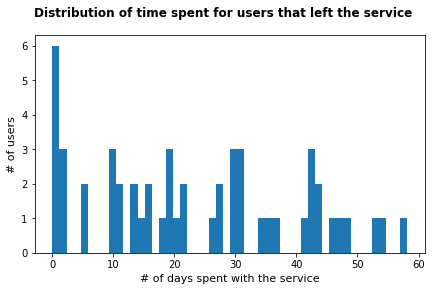

In [29]:
# Plot histogram fot time
fig = plt.figure(figsize=(7, 4))
fig.suptitle('Distribution of time spent for users that left the service', fontsize=12, fontweight='bold')

plt.hist(delta_time_cancelled, bins=50);
plt.xlabel('# of days spent with the service', fontsize=11)
plt.ylabel('# of users', fontsize=11);

In [30]:
# Look at the statistics
print('Statistics for time spent with the service for users that stayed:')
spark.createDataFrame(delta_time_cancelled, FloatType()).describe().show()

Statistics for time spent with the service for users that stayed:
+-------+------------------+
|summary|             value|
+-------+------------------+
|  count|                52|
|   mean|23.311283854087097|
| stddev|16.811958428031076|
|    min|       0.020393519|
|    max|          58.17678|
+-------+------------------+



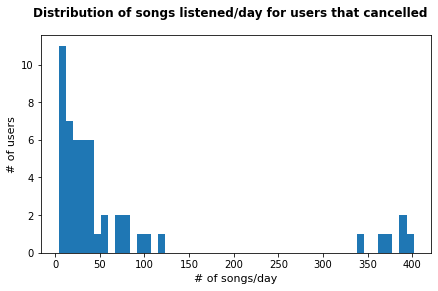

In [31]:
# Plot histogram for songs
fig = plt.figure(figsize=(7, 4))
fig.suptitle('Distribution of songs listened/day for users that cancelled', fontsize=12, fontweight='bold')

plt.hist(num_songs_cancelled, bins=50);
plt.xlabel('# of songs/day', fontsize=11)
plt.ylabel('# of users', fontsize=11);

In [32]:
# Look at the statistics
print('Statistics for songs/day for users that cancelled:')
spark.createDataFrame(num_songs_cancelled, FloatType()).describe().show()

Statistics for songs/day for users that cancelled:
+-------+------------------+
|summary|             value|
+-------+------------------+
|  count|                52|
|   mean| 72.82569125523933|
| stddev|114.11595391972978|
|    min|         3.9875815|
|    max|          401.4296|
+-------+------------------+



In [33]:
# Select, for every user that cancelled, the number of songs and the time span they spent with the service
song_time_stay = user_log_staying.\
                filter(user_log_staying["song"] != "").\
                groupBy("userId").\
                agg(min("ts"), max("ts"), countDistinct("song")).\
                collect()

In [34]:
# Get the difference
delta_time_staying = [(song_time[2]/1000 - song_time[1]/1000)/(3600*24) for song_time in song_time_stay]
# Get the number of songs listened per day day (on average)
num_songs_staying = [song_time[3]/((song_time[2]/1000 - song_time[1]/1000)/(3600*24)) for song_time in song_time_stay]

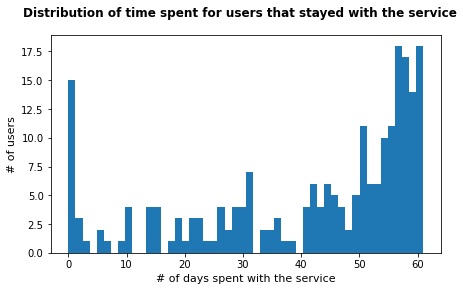

In [35]:
# Plot histogram for time
fig = plt.figure(figsize=(7, 4))
fig.suptitle('Distribution of time spent for users that stayed with the service', fontsize=12, fontweight='bold')

plt.hist(delta_time_staying, bins=50);
plt.xlabel('# of days spent with the service', fontsize=11)
plt.ylabel('# of users', fontsize=11);

In [36]:
# Look at the statistics
print('Statistics for time spent with the service for users that stayed:')
spark.createDataFrame(delta_time_staying, FloatType()).describe().show()

Statistics for time spent with the service for users that stayed:
+-------+------------------+
|summary|             value|
+-------+------------------+
|  count|               225|
|   mean| 41.27362795350452|
| stddev|19.127569947419758|
|    min|       0.004837963|
|    max|         60.997337|
+-------+------------------+



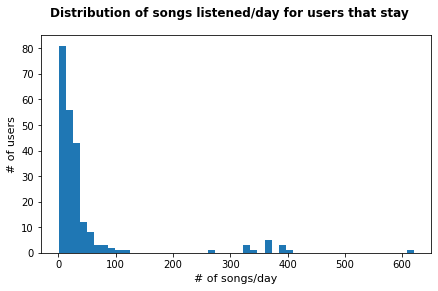

In [37]:
# Plot histogram for the songs
fig = plt.figure(figsize=(7, 4))
fig.suptitle('Distribution of songs listened/day for users that stay', fontsize=12, fontweight='bold')

plt.hist(num_songs_staying, bins=50);
plt.xlabel('# of songs/day', fontsize=11)
plt.ylabel('# of users', fontsize=11);

In [38]:
# Look at the statistics
print('Statistics for songs/day for users that stay:')
spark.createDataFrame(num_songs_staying, FloatType()).describe().show()

Statistics for songs/day for users that stay:
+-------+------------------+
|summary|             value|
+-------+------------------+
|  count|               225|
|   mean|45.927462125354346|
| stddev| 92.03630452378215|
|    min|        0.65271604|
|    max|          620.0957|
+-------+------------------+



We can check the quantiles for the num of songs/day

In [39]:
spark.createDataFrame(num_songs_cancelled, FloatType()).approxQuantile("value", [0.25, 0.5, 0.75], 0.25)

[3.987581491470337, 14.047821044921875, 401.4295959472656]

In [40]:
spark.createDataFrame(num_songs_staying, FloatType()).approxQuantile("value", [0.25, 0.5, 0.75], 0.25)

[0.6527160406112671, 14.75526237487793, 620.095703125]

Other maybe useful pages are thoe marked as `Roll Advert` or `Add Friend`

In [41]:
# Defining a roll_adv variable based on the Roll Advert page
roll_adv = udf(lambda x: 1 if x == "Roll Advert" else 0, IntegerType())  

user_log_cancelled = user_log_cancelled.withColumn("roll_adv", roll_adv("page"))
user_log_staying = user_log_staying.withColumn("roll_adv", roll_adv("page"))

In [42]:
# Defining an add_friend variable based on the Add Friend page
add_friend = udf(lambda x: 1 if x == "Add Friend" else 0, IntegerType())  

user_log_cancelled = user_log_cancelled.withColumn("add_friend", add_friend("page"))
user_log_staying = user_log_staying.withColumn("add_friend", add_friend("page"))

In [43]:
user_log_cancelled.head()

Row(artist='Modjo', auth='Logged In', firstName='Alexi', gender='F', itemInSession=0, lastName='Warren', length=250.93179, level='paid', location='Spokane-Spokane Valley, WA', method='PUT', page='NextSong', registration=1532482662000, sessionId=53, song='What I Mean', status=200, ts=1538353930000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:32.0) Gecko/20100101 Firefox/32.0', userId='54', churn=0, roll_adv=0, add_friend=0)

In [44]:
user_log_staying.head()

Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30', churn=0, roll_adv=0, add_friend=0)

In [51]:
added_friend_canc = user_log_cancelled.\
                groupBy("userId").\
                agg(Ssum("add_friend")).collect()

In [60]:
added_friend_event_canc = [added_friend[1] for added_friend in added_friend_canc]

In [53]:
added_friend_stay = user_log_staying.\
                groupBy("userId").\
                agg(Ssum("add_friend")).collect()

In [61]:
added_friend_event_stay = [added_friend[1] for added_friend in added_friend_stay]

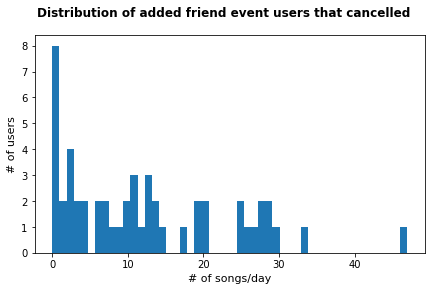

In [62]:
# Plot histogram for the added. friend event
fig = plt.figure(figsize=(7, 4))
fig.suptitle('Distribution of added friend event users that cancelled', fontsize=12, fontweight='bold')

plt.hist(added_friend_event_canc, bins=50);
plt.xlabel('# of friends added', fontsize=11)
plt.ylabel('# of users', fontsize=11);

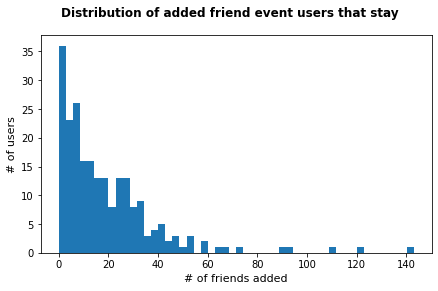

In [64]:
# Plot histogram for the added. friend event
fig = plt.figure(figsize=(7, 4))
fig.suptitle('Distribution of added friend event users that stay', fontsize=12, fontweight='bold')

plt.hist(added_friend_event_stay, bins=50);
plt.xlabel('# of friends added', fontsize=11)
plt.ylabel('# of users', fontsize=11);

In [54]:
rolled_advert_canc = user_log_cancelled.\
                groupBy("userId").\
                agg(Ssum("roll_adv")).collect()

In [65]:
rolled_advert_event_canc = [rolled_adv[1] for rolled_adv in rolled_advert_canc]

In [55]:
rolled_advert_stay = user_log_staying.\
                groupBy("userId").\
                agg(Ssum("roll_adv")).collect()

In [66]:
rolled_advert_event_stay = [rolled_adv[1] for rolled_adv in rolled_advert_stay]

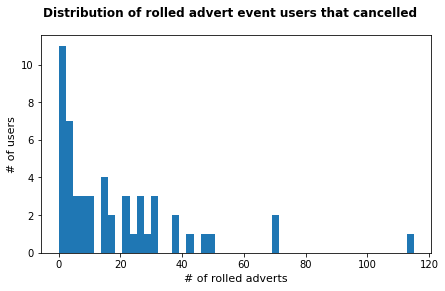

In [68]:
# Plot histogram for the rolled advert event
fig = plt.figure(figsize=(7, 4))
fig.suptitle('Distribution of rolled advert event users that cancelled', fontsize=12, fontweight='bold')

plt.hist(rolled_advert_event_canc, bins=50);
plt.xlabel('# of rolled adverts', fontsize=11)
plt.ylabel('# of users', fontsize=11);

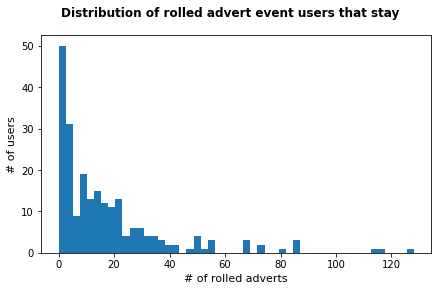

In [69]:
# Plot histogram for the rolled advert event
fig = plt.figure(figsize=(7, 4))
fig.suptitle('Distribution of rolled advert event users that stay', fontsize=12, fontweight='bold')

plt.hist(rolled_advert_event_stay, bins=50);
plt.xlabel('# of rolled adverts', fontsize=11)
plt.ylabel('# of users', fontsize=11);

In [ ]:
# window = Window.partitionBy("userId").rangeBetween(Window.unboundedPreceding, Window.unboundedFollowing)
# user_log_valid_2 = user_log_valid.withColumn("Schurn", Ssum("churn").over(window))

In [ ]:
# user_log_valid_2.head()

In [ ]:
# user_log_valid_2.tail(5)

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.